# Telco Customer Churn Prediction

Prediction customer churn using Machine LearnMing with focus on recall optimization.

## 1. Project Overview

This project analyzes customer churn for a fictional telecom company.  
The goal is to identify customers at high risk of leaving so the company can take proactive retention actions.

Because losing a customer is more costly than contacting a non-churner,  
**recall is the priority metric** — we want to catch as many churners as possible.

## 2. Dataset Description

The dataset contains 7,043 customers with demographic, service usage, and billing information.

Key fields include:
- **Demographics:** gender, senior citizen, partner, dependents  
- **Services:** phone, internet, security, backup, device protection, tech support  
- **Contract & Billing:** contract type, payment method, monthly charges, total charges  
- **Target:** `Churn` (Yes/No)

Source: IBM Telco Customer Churn dataset.

### 2.1 Feature Description

The dataset contains customer demographic information, service subscriptions, billing details, and churn labels.

**Demographics**
- `gender`: Male / Female  
- `SeniorCitizen`: Whether the customer is 65+  
- `Partner`: Yes / No  
- `Dependents`: Yes / No  

**Customer Tenure**
- `tenure`: Number of months the customer has stayed with the company  

**Phone & Internet Services**
- `PhoneService`: Yes / No  
- `MultipleLines`: Yes / No  
- `InternetService`: No / DSL / Fiber optic  
- `OnlineSecurity`: Yes / No  
- `OnlineBackup`: Yes / No  
- `DeviceProtection`: Yes / No  
- `TechSupport`: Yes / No  
- `StreamingTV`: Yes / No  
- `StreamingMovies`: Yes / No  

**Contract & Billing**
- `Contract`: Month-to-month / One year / Two year  
- `PaperlessBilling`: Yes / No  
- `PaymentMethod`: Bank withdrawal / Credit card / Mailed check  
- `MonthlyCharges`: Current monthly bill  
- `TotalCharges`: Total amount billed to date  

**Target Variable**
- `Churn`: Yes = customer left during the quarter, No = customer stayed

## 3. Import Libraries

In [3]:
# =============================
# 1. Core Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 2. Stats & Distributions
# =============================
from scipy.stats import uniform, randint

# =============================
# 3. Preprocessing & Model Selection
# =============================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# =============================
# 4. Metrics
# =============================
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    average_precision_score, classification_report)

# =============================
# 5. Models
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =============================
# 6. Explainability
# =============================
import shap

# =============================
# 7. Model Saving & Utilities
# =============================
import joblib


## 4. Data Loading & Cleaning

This section loads the dataset and performs initial cleaning steps to ensure data quality.

### Steps:
1. Load CSV  
2. Convert `TotalCharges` to numeric  
3. Remove rows with missing values (tenure = 0)  
4. Drop `customerID`  
5. Reset index

In [4]:
# Load dataset
data = pd.read_csv("Telco_Churn_data.csv")

# Convert TotalCharges to numeric (coerce errors to NaN)
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

# Drop customerID (not useful for modeling)
data.drop("customerID", axis=1, inplace=True)

# Remove rows where TotalCharges is NaN (tenure = 0)
data = data.dropna().reset_index(drop=True)

# Quick check
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 5. Exploratory Data Analysis (EDA)

Before modeling, we explore the dataset to understand the churn distribution and identify key patterns.

### 5.1 Target Distribution

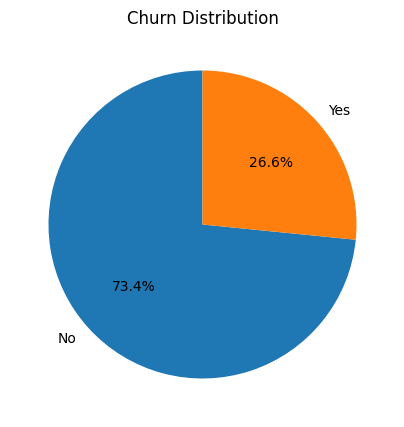

In [5]:
plt.figure(figsize=(5,5))
data['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['No','Yes'], startangle=90)
plt.title('Churn Distribution')
plt.ylabel('')
plt.show()

#### Key Insight :

- Churn rate is ~26%, indicating a slight imbalance but nothing requiring resampling at this stage.

### 5.2 Categorical Features vs Churn

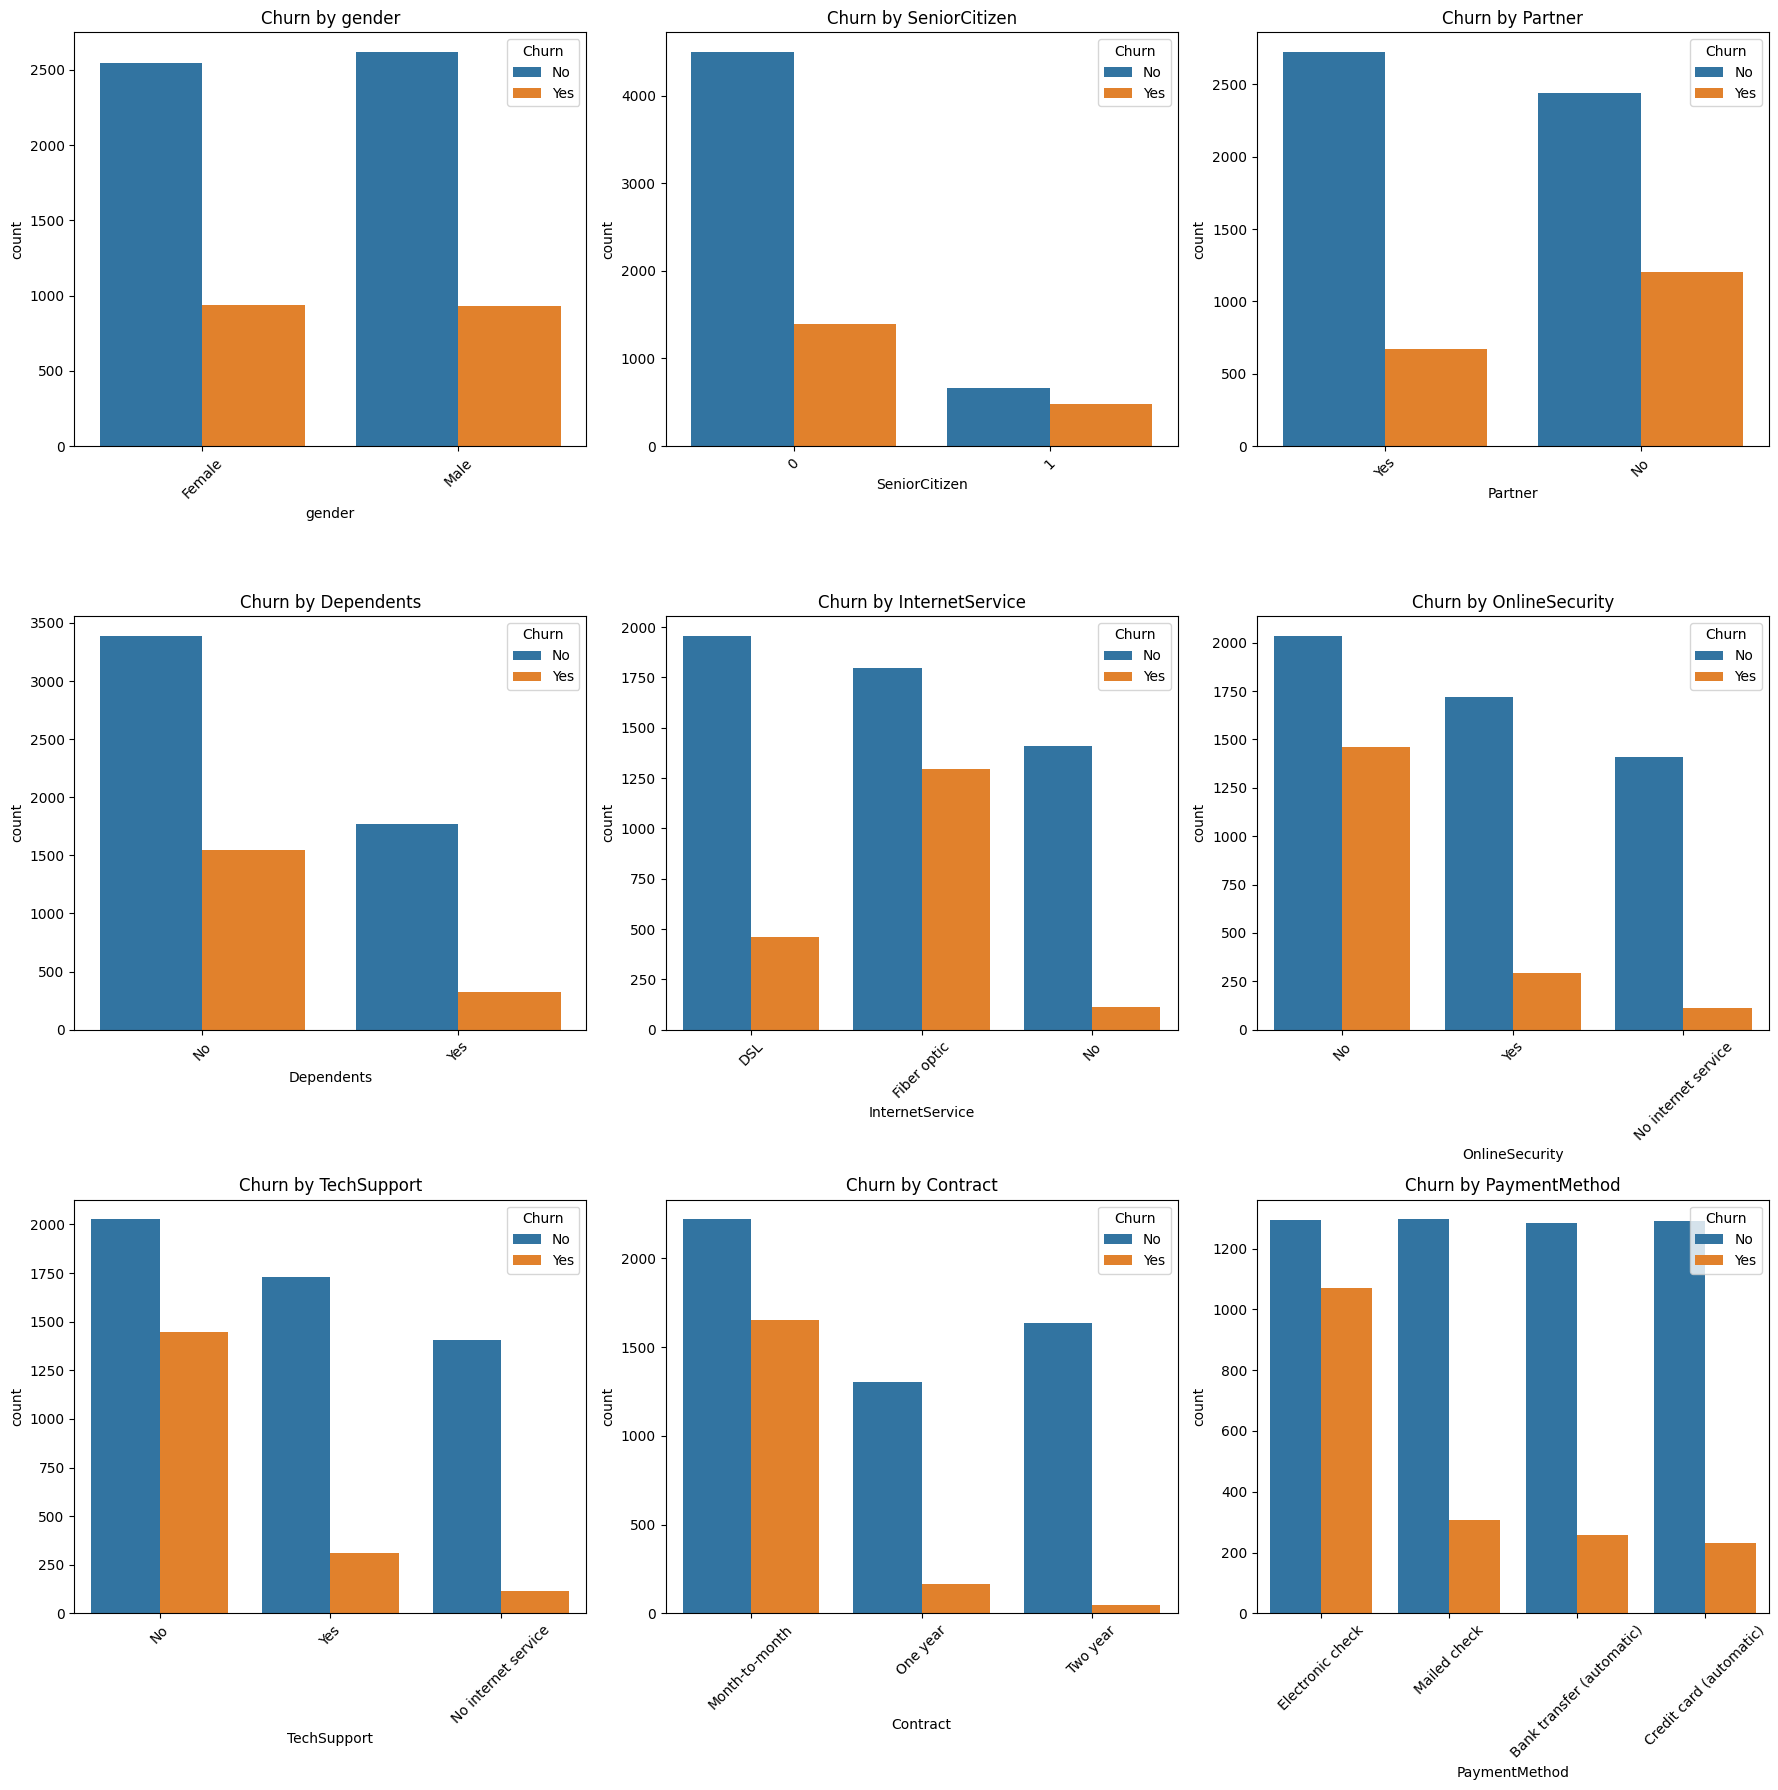

In [6]:
categorical_cols = [
    'gender','SeniorCitizen','Partner','Dependents','InternetService',
    'OnlineSecurity','TechSupport','Contract','PaymentMethod'
]

plt.figure(figsize=(18,18))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3,3,i)
    sns.countplot(data=data, x=col, hue='Churn')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Insights
- Senior citizens churn more.
- Customers with partners or dependents churn less.
- Month-to-month contracts have the highest churn.
- Fiber optic users churn more.
- Lack of online security/backup/tech support increases churn.
- High monthly charges + low tenure = high churn risk.

### 5.3 Numerical Features vs Churn

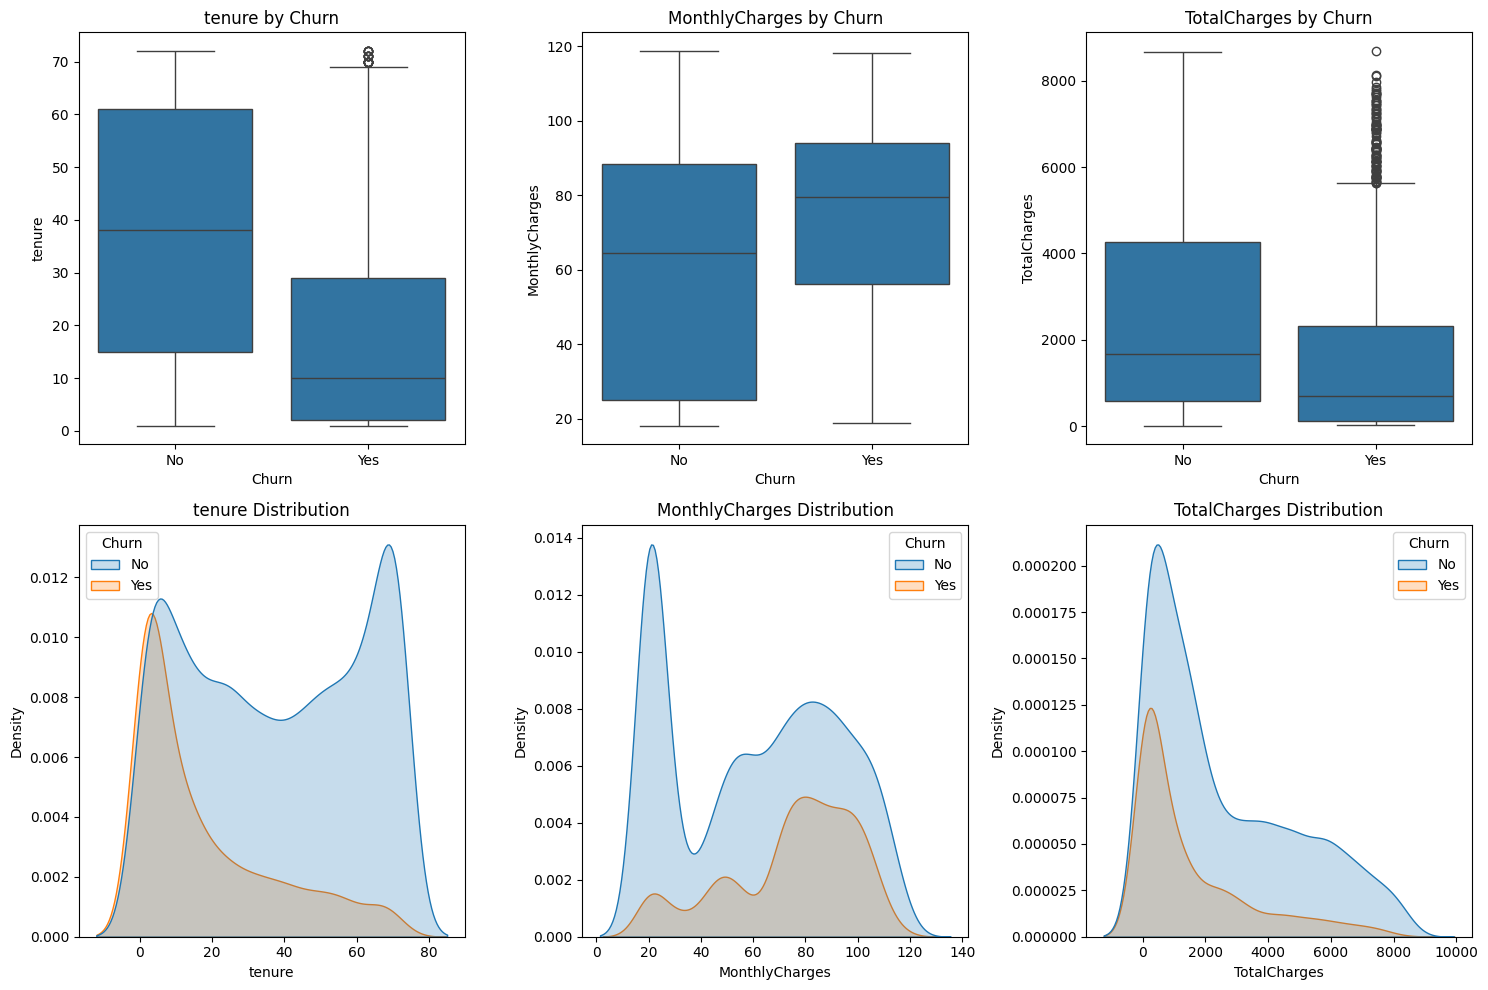

In [7]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x='Churn', y=col, data=data)
    plt.title(f'{col} by Churn')

    plt.subplot(2,3,i+3)
    sns.kdeplot(data=data, x=col, hue='Churn', fill=True)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

#### Interpretation :
- Customers with low tenure churn significantly more → new clients leave early.

- Customers with high monthly charges churn more → potential dissatisfaction with pricing.

- Churners have lower total charges → they leave before generating long‑term revenue.

## 6. Feature Engineering

This section prepares the dataset for modeling by transforming categorical variables, removing redundant features, and standardizing numerical values.
### Steps
- Drop redundant features (`PhoneService`)
- Convert binary categorical variables to 0/1
- One‑hot encode multi‑category features
- Remove redundant dummy variables (e.g., “No internet service”)
- Standardize numerical features (`tenure`, `MonthlyCharges`, `TotalCharges`)

In [8]:
# 1. Drop redundant feature
data.drop('PhoneService', axis=1, inplace=True)

# 2. Convert binary categorical variables to 0/1
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling']
for col in binary_cols:
    data[col] = (data[col] == 'Yes').astype(int)

# gender is special case
data['gender'] = (data['gender'] == 'Male').astype(int)

# Target
data['Churn'] = (data['Churn']=='Yes').astype(int)

# 3. One-hot encode multi-category features
data_dum = pd.get_dummies(data, drop_first=False, dtype=int)

# 4. Remove "No internet service" redundant dummies
no_internet_cols = [col for col in data_dum.columns if "No internet service" in col]
data_dum.drop(no_internet_cols, axis=1, inplace=True)

# 5. Remove "No" dummies for service features (keep only the "Yes")
redundant_no_cols = [
    'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No',
    'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No', 'MultipleLines_No'
]
data_dum.drop(redundant_no_cols, axis=1, inplace=True)

# 6. Rename remaining "Yes" columns to clean names
rename_map = {
    'OnlineSecurity_Yes': 'OnlineSecurity',
    'OnlineBackup_Yes': 'OnlineBackup',
    'DeviceProtection_Yes': 'DeviceProtection',
    'TechSupport_Yes': 'TechSupport',
    'StreamingTV_Yes': 'StreamingTV',
    'StreamingMovies_Yes': 'StreamingMovies',
    'MultipleLines_Yes': 'MultipleLines'
}
data_dum.rename(columns=rename_map, inplace=True)

data_dum.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,...,TechSupport,StreamingTV,StreamingMovies,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,1,29.85,29.85,0,1,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,0,56.95,1889.50,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,53.85,108.15,1,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,42.30,1840.75,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,70.70,151.65,1,0,...,0,0,0,1,0,0,0,0,1,0


## 7. Correlation Analysis

We compute Spearman correlations to capture monotonic relationships between features and churn.

### Key correlations with churn
- **Contract_Month-to-month** → strong positive correlation
- **Tenure** → strong negative correlation
- **Fiber optic** → moderate positive correlation

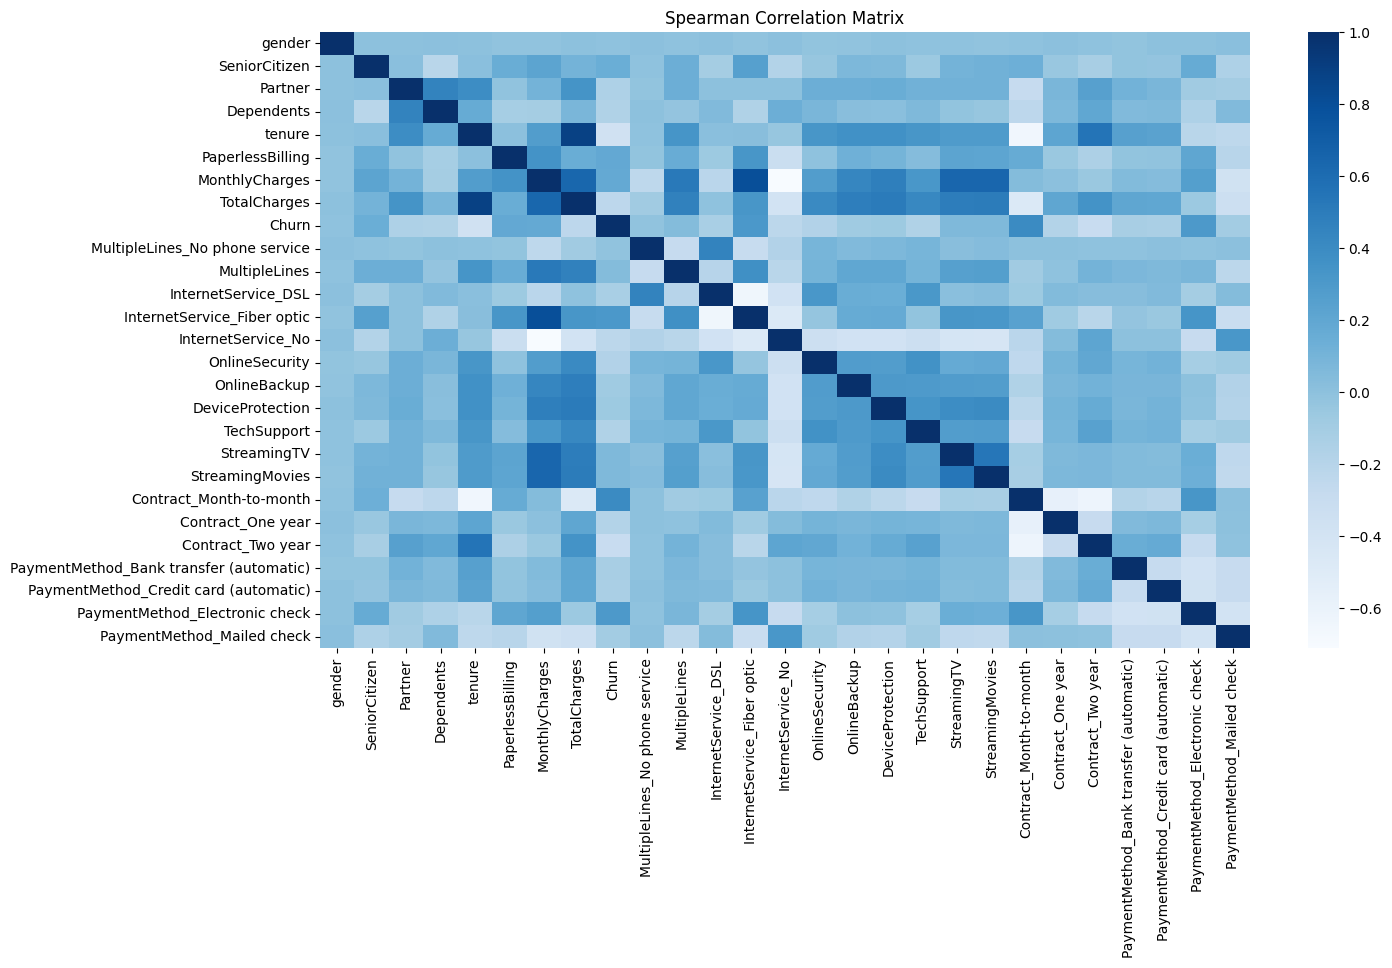

In [9]:
corr = data_dum.corr(method='spearman')

plt.figure(figsize=(15,8))
sns.heatmap(corr, cmap='Blues', annot=False)
plt.title('Spearman Correlation Matrix')
plt.show()

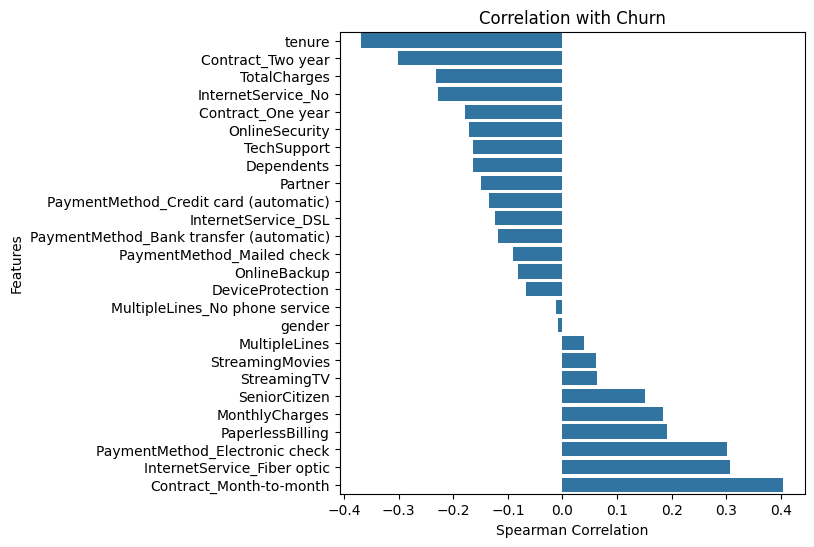

In [10]:
plt.figure(figsize=(6,6))
corr_churn = corr['Churn'].drop('Churn').sort_values()

sns.barplot(x=corr_churn.values, y=corr_churn.index, orient='h')
plt.title("Correlation with Churn")
plt.xlabel("Spearman Correlation")
plt.ylabel("Features")
plt.show()

### Interpretation

- Month-to-month contracts show the strongest positive correlation with churn, confirming that short-term customers are more likely to leave.
- Tenure has a strong negative correlation with churn, meaning long-term customers are significantly more loyal.
- Fiber optic users show higher churn, which may be linked to higher pricing or service expectations.

## 8. Modeling

We evaluate five supervised learning models for churn

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Classifier (SVC)
- Random Forest
- XGBoost

### Evaluation Metrics

Since churn prediction is a **high‑recall problem**, we prioritize:
- **Recall** (primary metric)
- Precision
- F1-score
- Average Precision (PR-AUC)

In [11]:
# Train-test split (80/20)
X = data_dum.drop('Churn', axis=1)
y = data_dum['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1, shuffle=True
)

# Scale numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 26), (1407, 26), (5625,), (1407,))

### Baseline = Always predict "No churn"

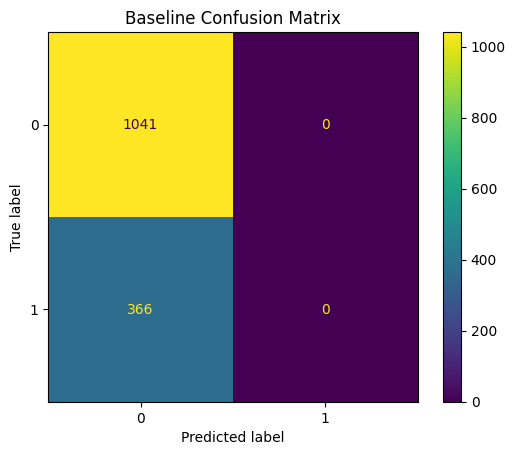

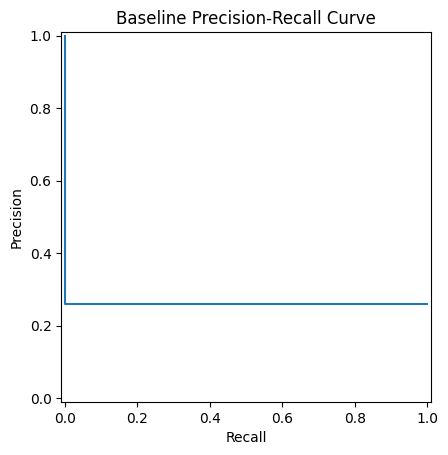

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1041
           1       0.00      0.00      0.00       366

    accuracy                           0.74      1407
   macro avg       0.37      0.50      0.43      1407
weighted avg       0.55      0.74      0.63      1407



In [12]:
# Baseline: predict 0 for all customers
baseline_pred = np.zeros_like(y_test)

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, baseline_pred)).plot()
plt.title("Baseline Confusion Matrix")
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, baseline_pred)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Baseline Precision-Recall Curve")
plt.show()

# Classification report
print(classification_report(y_test, baseline_pred, zero_division=0))

#### Interpretation

- The baseline model predicts **no churn for everyone**, resulting in:
  - Recall = 0  
  - Precision = 0  
  - F1-score = 0  
  - PR-AUC ≈ churn rate (~0.26)

This confirms that any meaningful model must significantly outperform this trivial baseline, especially in **recall**, which is the key metric for churn prevention.

## 9. Hyperparameter Optimization

To improve model performance, we apply a **two‑stage RandomizedSearchCV** strategy focused on maximizing **recall**, the key metric for churn prediction.

### 🔹 Stage 1 — Broad Search
A coarse search over wide parameter ranges:
- `n_iter = 20`
- `cv = 3`
- `sample_frac = 0.5` (to speed up exploration)

Goal: identify promising regions of the hyperparameter space.

### 🔹 Stage 2 — Refined Search
A focused search around the best regions found in Stage 1:
- `n_iter = 50`
- `cv = 5`
- `sample_frac = 1` (full dataset)

Goal: obtain the best hyperparameters for each model.

### 🔹 Stage 3 — Fit Optimized Models

### Models Tuned
- Logistic Regression  
- KNN  
- SVC  
- Random Forest  
- XGBoost  

The final optimized parameters are saved and used to train the final models.

In [13]:
def cv(model,distrib,X=X_train,y=y_train,n_cv=5,n_iter=50,sample_frac=1) :
    if sample_frac < 1.0:
      sample_idx = np.random.choice(len(X), int(len(X)*sample_frac), replace=False)
      X = X.iloc[sample_idx]
      y = y.iloc[sample_idx]
    process = RandomizedSearchCV(estimator=model, param_distributions=distrib, n_iter=n_iter, scoring="recall", cv=n_cv, verbose=0, n_jobs=-1, random_state=1)
    process.fit(X,y)
    return process.best_params_, process.best_score_

### 🔹 Stage 1 — Broad Search

In [14]:
print("===== Stage 1: Broad Search =====")

===== Stage 1: Broad Search =====


In [15]:
# Define the different models and their distributions for Broad Search
reglog=LogisticRegression()
reglog_distrib = {'C': uniform(0.0001,100), 'max_iter': [100, 200, 500]}

knn=KNeighborsClassifier()
knn_distrib = {'n_neighbors' : randint(3,20), 'weights' : ['uniform','distance'],}

svc = SVC()
svc_distrib = {'C': uniform(0.0001,100), 'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'], 'coef0': uniform(0,1)}

rf = RandomForestClassifier()
rf_distrib = {'n_estimators' : randint(50,501), 'max_depth':[None, 10, 20, 30, 50], 'min_samples_split': randint(2,11),
           'min_samples_leaf': randint(1,6), 'max_features':["sqrt", "log2", None]}

xgb = XGBClassifier()
xgb_distrib = {'n_estimators' : randint(50,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'gamma' : uniform(0,5), 'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10)}


models = [reglog, knn, svc, rf, xgb]
distribs = [reglog_distrib, knn_distrib, svc_distrib, rf_distrib, xgb_distrib]
model_names= ['Logistic Reg','KNN','SVC','RandomForest','Xgboost']

In [16]:
params_fin=dict()
res_fin=dict()

for (model, distrib, model_name) in zip(models,distribs,model_names) :
    print(model_name)
    param, score=cv(model,distrib,n_cv=3,n_iter=20,sample_frac=0.5)
    params_fin[model_name]=param
    res_fin[model_name]=score

Logistic Reg
KNN
SVC
RandomForest
Xgboost


In [17]:
print("\n===== Stage 1 Results =====")
for model_name in model_names:
    print(f"{model_name}: recall={res_fin[model_name]:.3f}, params={params_fin[model_name]}")


===== Stage 1 Results =====
Logistic Reg: recall=0.532, params={'C': np.float64(59.30665182980569), 'max_iter': 500}
KNN: recall=0.578, params={'n_neighbors': 17, 'weights': 'uniform'}
SVC: recall=0.547, params={'C': np.float64(90.85965030930956), 'coef0': np.float64(0.2936141483736795), 'gamma': 'auto', 'kernel': 'rbf'}
RandomForest: recall=0.505, params={'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 72}
Xgboost: recall=0.553, params={'colsample_bytree': np.float64(0.6185134901215139), 'gamma': np.float64(4.516897602811269), 'learning_rate': np.float64(0.17310384600168574), 'max_depth': 6, 'n_estimators': 451, 'reg_alpha': np.float64(1.6292982255402877), 'reg_lambda': np.float64(5.886339307357229), 'subsample': np.float64(0.5045039984805215)}


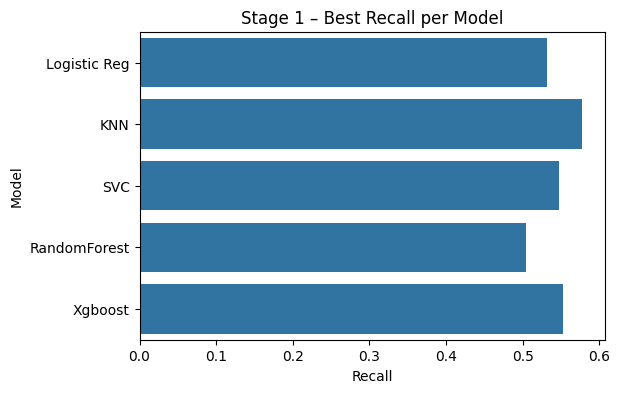

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(res_fin.values()), y=list(res_fin.keys()), orient='h')
plt.title("Stage 1 – Best Recall per Model")
plt.xlabel("Recall")
plt.ylabel("Model")
plt.show()

### 🔹 Stage 2 — Refined Search

In [19]:
print("===== Stage 2: Refined Search =====")

===== Stage 2: Refined Search =====


In [20]:
# Define the different models and their distributions for Refined Search
reglog=LogisticRegression(max_iter=100)
reglog_distrib = {'C': uniform(40,5)}

knn=KNeighborsClassifier(weights='uniform')
knn_distrib = {'n_neighbors' : randint(8,20)}

svc = SVC(gamma='auto',kernel='rbf')
svc_distrib = {'C': uniform(90,20)}

rf = RandomForestClassifier(max_features=None)
rf_distrib = {'n_estimators' : randint(50,200), 'max_depth': randint(5,13), 'min_samples_split': randint(7,13),
           'min_samples_leaf': randint(1,6)}

xgb = XGBClassifier()
xgb_distrib = {'n_estimators' : randint(150,250), 'max_depth': randint(3,10), 'subsample': uniform(0.6,0.3), 'learning_rate' : uniform(0.05,0.2), 'colsample_bytree': uniform(0.79,0.2),
            'gamma' : uniform(1,3), 'reg_alpha' : uniform(1.5,2), 'reg_lambda' : uniform(0.5,2)}

models = [reglog, knn, svc, rf, xgb]
distribs = [reglog_distrib, knn_distrib, svc_distrib, rf_distrib, xgb_distrib]
model_names= ['Logistic Reg','KNN','SVC','RandomForest','Xgboost']

In [21]:
params=dict()
res=dict()
for (model, distrib, model_name) in zip(models,distribs,model_names) :
    print(model_name)
    param, score=cv(model,distrib,n_cv=5,n_iter=50)
    params[model_name]=param
    res[model_name]=score

Logistic Reg
KNN
SVC
RandomForest
Xgboost


In [22]:
print("\n===== Stage 2 Results =====")
for model_name in model_names:
    print(f"{model_name}: recall={res[model_name]:.3f}, params={params[model_name]}")


===== Stage 2 Results =====
Logistic Reg: recall=0.555, params={'C': np.float64(42.08511002351287)}
KNN: recall=0.562, params={'n_neighbors': 19}
SVC: recall=0.540, params={'C': np.float64(104.40648986884317)}
RandomForest: recall=0.531, params={'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 71}
Xgboost: recall=0.562, params={'colsample_bytree': np.float64(0.7931066551101672), 'gamma': np.float64(2.7804442245899117), 'learning_rate': np.float64(0.13673526979789166), 'max_depth': 5, 'n_estimators': 245, 'reg_alpha': np.float64(2.130489606190746), 'reg_lambda': np.float64(2.2857774170503027), 'subsample': np.float64(0.7733571645853606)}


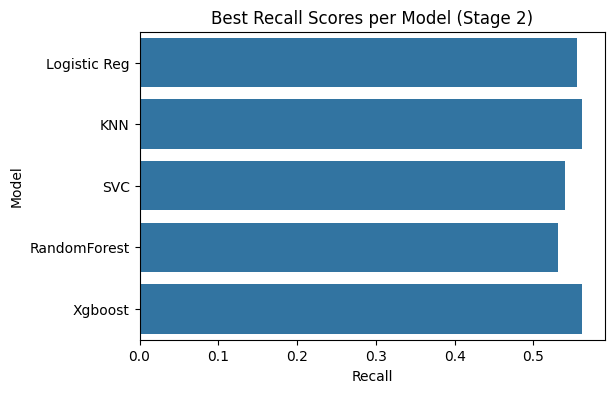

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(res.values()), y=list(res.keys()), orient='h')
plt.title("Best Recall Scores per Model (Stage 2)")
plt.xlabel("Recall")
plt.ylabel("Model")
plt.show()

In [24]:
# Save the optimized parameters to a file
joblib.dump(params, "optimized_params.pkl")

['optimized_params.pkl']

###🔹 Stage 3 — Fit Optimized Models

In [25]:
print("===== Stage 3: Fit Optimized Models =====")

===== Stage 3: Fit Optimized Models =====


In [26]:
params= joblib.load("optimized_params.pkl")

In [27]:
# Optimized Models :
reglog = LogisticRegression(**params['Logistic Reg'])

knn = KNeighborsClassifier(**params['KNN'])

svc = SVC(**params['SVC'],probability=True)

rf = RandomForestClassifier(**params['RandomForest'])

xgb = XGBClassifier(**params['Xgboost'])

models = [reglog, knn, svc, rf,xgb]
model_names=['Logistic Reg','KNN','SVC','RandomForest','Xgboost']

In [28]:
for model,model_name in zip(models,model_names) :
  model.fit(X_train,y_train)

#### Interpretation

- The two‑stage RandomizedSearchCV approach efficiently explores the hyperparameter space.
- XGBoost and Random Forest generally achieve the highest recall during optimization.
- Logistic Regression remains competitive but less flexible.
- KNN and SVC require careful tuning and are more sensitive to scaling and class imbalance.
- The refined search (Stage 2) significantly improves recall compared to the broad search.

The optimized models are now ready for final evaluation on the test set.

## 10. Model Evaluation

We evaluate all optimized models on the held‑out test set using:

- **Recall** (primary metric)
- Precision
- F1‑score
- Accuracy
- Average Precision (PR‑AUC)

The baseline model (predicting “No churn” for everyone) achieves:
- **Recall = 0.00**
- **PR‑AUC ≈ churn rate (~0.26)**

The best model at default threshold is **Logistic Regression** with:
- **Recall ≈ 0.56**
- but relatively low PR‑AUC

This indicates that default thresholds are insufficient for a churn‑prevention use case.

In [29]:
# Containers
metrics = {
    "Model": [],
    "Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1": [],
    "AP": []
}

# --- Evaluate all models ---
for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}\n", classification_report(y_test, y_pred))

    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["F1"].append(f1_score(y_test, y_pred))
    metrics["AP"].append(average_precision_score(y_test, y_prob))

# --- Baseline ---
baseline_pred = np.zeros_like(y_test)

metrics["Model"].append("Baseline")
metrics["Accuracy"].append(accuracy_score(y_test, baseline_pred))
metrics["Recall"].append(recall_score(y_test, baseline_pred))
metrics["Precision"].append(precision_score(y_test, baseline_pred,zero_division=0))
metrics["F1"].append(f1_score(y_test, baseline_pred))
metrics["AP"].append(average_precision_score(y_test, baseline_pred))

# --- Final table ---
results = pd.DataFrame(metrics)
results


Logistic Reg
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1041
           1       0.63      0.54      0.58       366

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407


KNN
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1041
           1       0.59      0.56      0.58       366

    accuracy                           0.78      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.78      0.78      0.78      1407


SVC
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1041
           1       0.51      0.54      0.52       366

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.67      1407
weighted avg       0.75      0.74      0.75    

,Model,Accuracy,Recall,Precision,F1,AP
0,Logistic Reg,0.797441,0.538251,0.629393,0.580265,0.641560
1,KNN,0.783937,0.562842,0.588571,0.575419,0.598694
2,SVC,0.743426,0.535519,0.506460,0.520584,0.473325
3,RandomForest,0.796020,0.480874,0.644689,0.550861,0.655235
4,Xgboost,0.796020,0.510929,0.633898,0.565809,0.656853
5,Baseline,0.739872,0.000000,0.000000,0.000000,0.260128


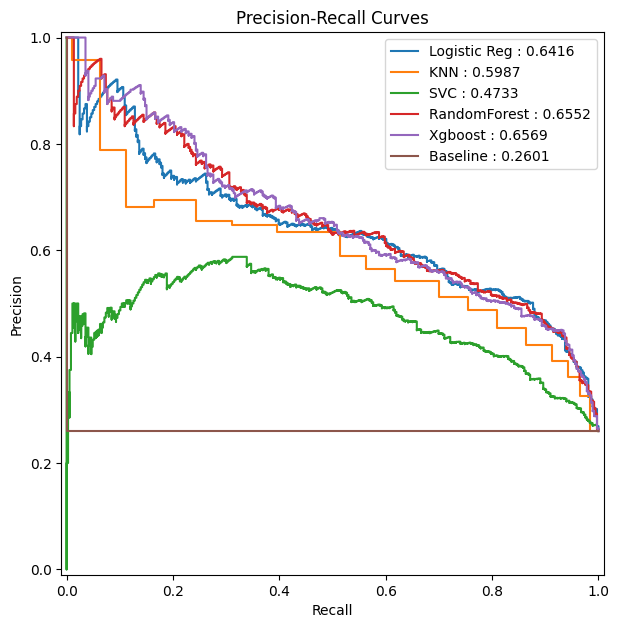

In [30]:
precision = {}
recall = {}
thresholds = {}
average_precision = {}
labels_pr = []

# Courbes PR pour les modèles
for i, (model, model_name) in enumerate(zip(models, model_names)):
    y_prob = model.predict_proba(X_test)[:, 1]
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test, y_prob)
    average_precision[i] = average_precision_score(y_test, y_prob)
    labels_pr.append(f"{model_name} : {average_precision[i]:.4f}")

# Baseline : prédire toujours 0
baseline_scores = 0 * y_test
i_baseline = len(models)

precision[i_baseline], recall[i_baseline], thresholds[i_baseline] = precision_recall_curve(y_test, baseline_scores)
average_precision[i_baseline] = average_precision_score(y_test, baseline_scores)
labels_pr.append(f"Baseline : {average_precision[i_baseline]:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 8))

for i in range(len(labels_pr)):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, despine=False)

ax.legend(labels_pr)
plt.title("Precision-Recall Curves")
plt.show()

In [31]:
results = pd.DataFrame(metrics)
results.sort_values(by='AP', ascending=False).style.background_gradient(cmap='viridis')

,Model,Accuracy,Recall,Precision,F1,AP
4,Xgboost,0.796020,0.510929,0.633898,0.565809,0.656853
3,RandomForest,0.796020,0.480874,0.644689,0.550861,0.655235
0,Logistic Reg,0.797441,0.538251,0.629393,0.580265,0.641560
1,KNN,0.783937,0.562842,0.588571,0.575419,0.598694
2,SVC,0.743426,0.535519,0.506460,0.520584,0.473325
5,Baseline,0.739872,0.000000,0.000000,0.000000,0.260128


#### Interpretation

- Logistic Regression achieves the highest recall at the default threshold (~0.56), but its PR‑AUC remains modest.
- Random Forest and XGBoost show better PR‑AUC but lower recall at threshold 0.5.
- All models struggle to balance recall and precision at the default threshold.
- Since churn prediction is a **high‑recall problem**, default thresholds are not suitable.

#### Conclusion

To improve recall, we must **adjust the decision threshold** using the predicted probabilities.  
This is addressed in the next section.


## 11. Threshold Optimization

To increase recall, we adjust the decision threshold.

Target recalls:
- **0.70**
- **0.80**

Best configuration:
- **Logistic Regression**
- Threshold ≈ **0.29**
- Recall ≈ **0.80**
- Precision ≈ **0.52**

In [32]:
# Logistic Reg (0), RandomForest (3), XGBoost (4)
selected_idx = [0, 3, 4]

selected_models = [models[i] for i in selected_idx]
selected_names = [model_names[i] for i in selected_idx]

selected_precision = [precision[i] for i in selected_idx]
selected_recall = [recall[i] for i in selected_idx]
selected_thresholds = [thresholds[i] for i in selected_idx]
selected_ap = [average_precision[i] for i in selected_idx]

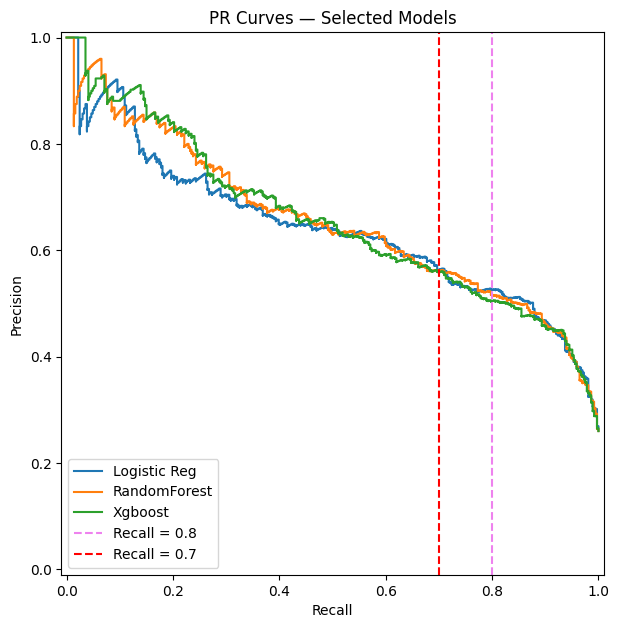

In [33]:
fig, ax = plt.subplots(figsize=(7, 8))

for i in range(len(selected_models)):
    display = PrecisionRecallDisplay(
        recall=selected_recall[i],
        precision=selected_precision[i],
        average_precision=selected_ap[i],
    )
    display.plot(ax=ax, despine=False)

plt.axvline(x=0.8, color='violet', linestyle='--', label='Target Recall = 0.8')
plt.axvline(x=0.7, color='red', linestyle='--', label='Target Recall = 0.7')

ax.legend(selected_names + ['Recall = 0.8', 'Recall = 0.7'])
plt.title("PR Curves — Selected Models")
plt.show()

In [34]:
target_recalls = [0.7, 0.8]

threshold_results = {}

for name, r, p, th in zip(selected_names, selected_recall, selected_precision, selected_thresholds):
    threshold_results[name] = {}
    for target in target_recalls:
        idx = np.where(r >= target)[0][-1]
        threshold_results[name][target] = {
            "threshold": th[idx],
            "precision": p[idx],
            "recall": r[idx]
        }


In [35]:
for name in selected_names:
    print(f"\n{name}")
    for target in target_recalls:
        info = threshold_results[name][target]
        print(f"  Target Recall = {target}")
        print(f"    - Threshold = {info['threshold']:.3f}")
        print(f"    - Precision = {info['precision']:.3f}")
        print(f"    - Recall    = {info['recall']:.3f}")


Logistic Reg
  Target Recall = 0.7
    - Threshold = 0.375
    - Precision = 0.564
    - Recall    = 0.702
  Target Recall = 0.8
    - Threshold = 0.293
    - Precision = 0.526
    - Recall    = 0.801

RandomForest
  Target Recall = 0.7
    - Threshold = 0.357
    - Precision = 0.561
    - Recall    = 0.702
  Target Recall = 0.8
    - Threshold = 0.282
    - Precision = 0.517
    - Recall    = 0.801

Xgboost
  Target Recall = 0.7
    - Threshold = 0.351
    - Precision = 0.559
    - Recall    = 0.702
  Target Recall = 0.8
    - Threshold = 0.267
    - Precision = 0.504
    - Recall    = 0.801


In [36]:
predictions = {}

for name, model in zip(selected_names, selected_models):
    y_prob = model.predict_proba(X_test)[:, 1]
    predictions[name] = {
        0.7: (y_prob >= threshold_results[name][0.7]["threshold"]),
        0.8: (y_prob >= threshold_results[name][0.8]["threshold"])
    }

In [37]:
rows = []

# Default threshold = 0.5
for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    rows.append({
        "Model": name,
        "Threshold": 0.5,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

# Thresholds 0.7 and 0.8
for name in selected_names:
    for target in target_recalls:
        y_pred = predictions[name][target]
        rows.append({
            "Model": f"{name} (Recall {target})",
            "Threshold": threshold_results[name][target]["threshold"],
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred)
        })

results_threshold = pd.DataFrame(rows)
results_threshold.sort_values(by=["Recall","Precision"], ascending=False).reset_index(drop=True).style.background_gradient(cmap='viridis')

,Model,Threshold,Accuracy,Recall,Precision,F1
0,Logistic Reg (Recall 0.8),0.292955,0.760483,0.800546,0.526032,0.634886
1,RandomForest (Recall 0.8),0.282200,0.753376,0.800546,0.516755,0.628081
2,Xgboost (Recall 0.8),0.266997,0.743426,0.800546,0.504303,0.618796
3,Logistic Reg (Recall 0.7),0.375494,0.781095,0.702186,0.563596,0.625304
4,RandomForest (Recall 0.7),0.357114,0.779673,0.702186,0.561135,0.623786
5,Xgboost (Recall 0.7),0.350559,0.778252,0.702186,0.558696,0.622276
6,KNN,0.500000,0.783937,0.562842,0.588571,0.575419
7,Logistic Reg,0.500000,0.797441,0.538251,0.629393,0.580265
8,SVC,0.500000,0.743426,0.535519,0.506460,0.520584
9,Xgboost,0.500000,0.796020,0.510929,0.633898,0.565809


## 12. Confusion Matrix (Optimized Threshold = 0.29)

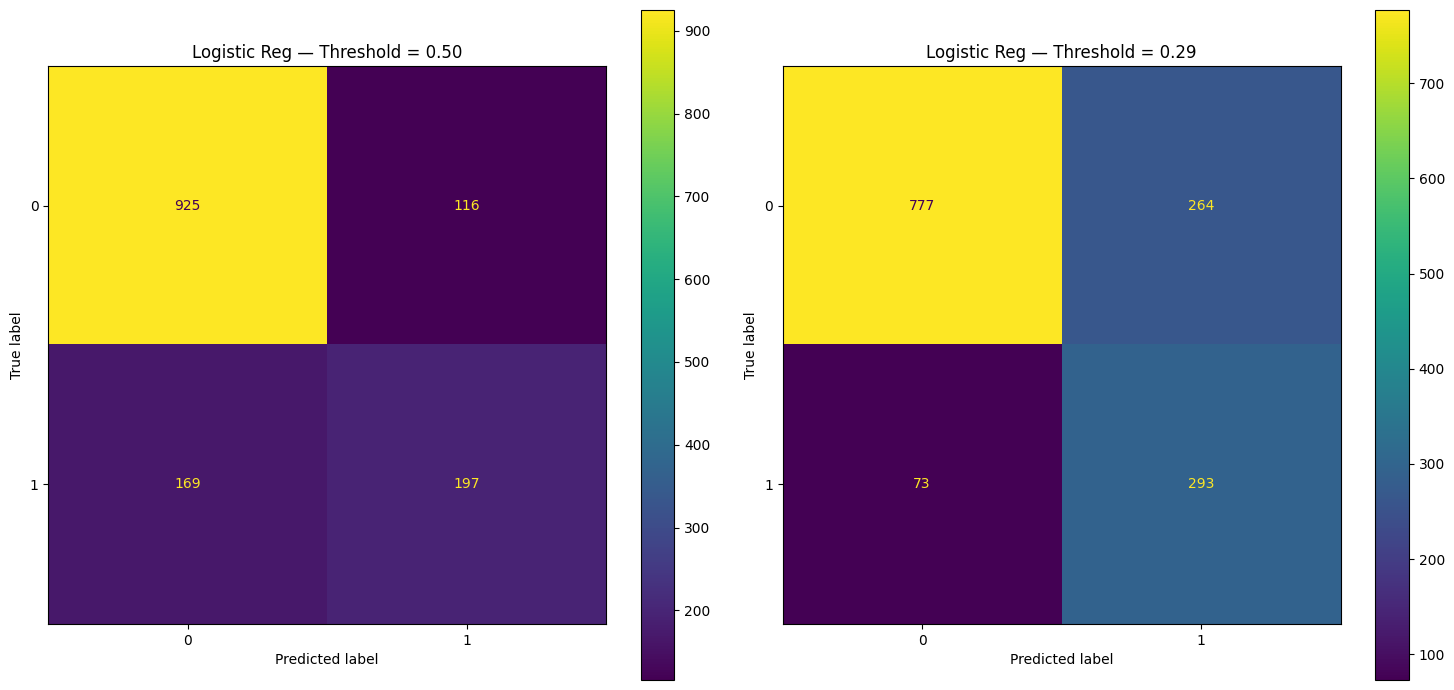

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Threshold 0.5
y_pred_default = selected_models[0].predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_default, ax=axes[0])
axes[0].set_title(f"{best_model_name} — Threshold = 0.50")

# Threshold optimisé
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, ax=axes[1])
axes[1].set_title(f"{best_model_name} — Threshold = {best_threshold:.2f}")

plt.tight_layout()
plt.show()

## 13. Feature Importance

Using Logistic Regression coefficients, XGBoost Gain-Based Feature *Importance* and Random Forest Gini Importance.

Top predictors across models:
- Tenure  
- Contract type  
- TotalCharges  
- InternetService_Fiber optic  

### 🔹 1. Logistic Regression

In [44]:
weights = pd.Series(
    reglog.coef_[0],
    index=X_train.columns
)

top_10_lr = weights.abs().sort_values(ascending=False).head(10).index
weights[top_10_lr].sort_values(ascending=False)

,0
InternetService_Fiber optic,1.334798
StreamingMovies,0.725047
TotalCharges,0.700328
StreamingTV,0.689142
InternetService_DSL,-0.565786
PaymentMethod_Mailed check,-0.574334
Contract_Two year,-1.305267
MonthlyCharges,-1.374944
tenure,-1.475880
InternetService_No,-2.449047


###🔹 2. XGBoost

In [50]:
feat_imp_xgb = pd.DataFrame(
    xgb.get_booster().get_score(importance_type='gain'),
    index=['importance']
).T

top_10_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False).head(10).index
feat_imp_xgb.loc[top_10_xgb].sort_values(by='importance', ascending=False)

,importance
Contract_Month-to-month,218.505478
InternetService_Fiber optic,47.194271
Contract_Two year,24.300989
PaymentMethod_Electronic check,22.162857
TotalCharges,11.712452
Contract_One year,9.373144
StreamingMovies,9.358420
InternetService_DSL,8.788607
tenure,8.668102
PaperlessBilling,8.442133


### 🔹 3. Random Forest

In [51]:
feat_imp_rf = pd.DataFrame(
    rf.feature_importances_,
    index=X_train.columns,
    columns=['importance']
)

top_10_rf = feat_imp_rf.sort_values(by='importance', ascending=False).head(10).index
feat_imp_rf.loc[top_10_rf].sort_values(by='importance', ascending=False)

,importance
tenure,0.172380
TotalCharges,0.143814
Contract_Month-to-month,0.127094
MonthlyCharges,0.123218
InternetService_Fiber optic,0.082753
Contract_Two year,0.057936
PaymentMethod_Electronic check,0.045764
PaperlessBilling,0.023037
InternetService_No,0.022504
Contract_One year,0.020016


### 🔹 4. Most frequent in top 10

In [55]:
list_imp = list(top_10_rf) + list(top_10_xgb) + list(top_10_lr)

freq_series = pd.Series(list_imp).value_counts()
freq_series[freq_series > 1]

,count
tenure,3
TotalCharges,3
Contract_Two year,3
InternetService_Fiber optic,3
MonthlyCharges,2
Contract_Month-to-month,2
PaymentMethod_Electronic check,2
PaperlessBilling,2
InternetService_No,2
Contract_One year,2


## 14. SHAP Explainability

SHAP provides both global and local interpretability for the model’s predictions.
Here, we apply SHAP to the Logistic Regression model, which is both one of the top performers and the most interpretable.

SHAP confirms:
- New customers churn more.
- Fiber optic users churn more.
- Long-term contracts reduce churn.
- High TotalCharges increases churn risk.

### 🔹 1. SHAP Values (Global Explanation)

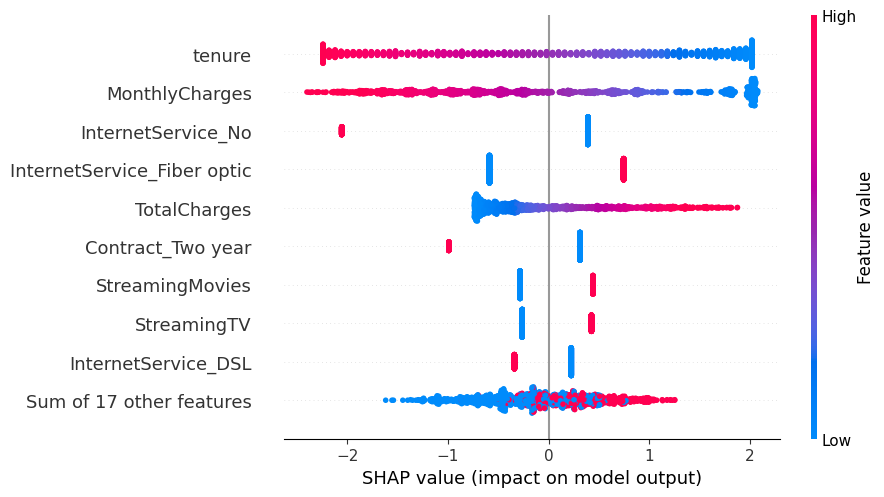

In [58]:
explainer = shap.explainers.Linear(reglog, X_test)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

###🔹   2. SHAP Summary Interpretation

The SHAP summary plot highlights the most influential features driving churn predictions :

- **Tenure** is the strongest predictor : new customers are significantly more likely to churn.
- **TotalCharges** shows that high spenders are at higher risk. This may reflect accumulated dissatisfaction or billing issues.
- **InternetService_Fiber optic** shows that fiber optic users tend to churn more frequently. This could indicate service quality concerns or unmet expectations.
- **Contract Type** shows that ong-term contracts (1-year or 2-year) strongly reduce churn probability. This is a clear business lever: promoting longer commitments can improve retention.
- **MonthlyCharges** Interestingly, higher monthly charges are associated with lower churn. This likely reflects customers who subscribe to multiple services or are under long-term contracts, making them more loyal.

###🔹 3. Business Implications
SHAP insights translate directly into actionable retention strategies:

Prioritize new customers with onboarding support and early engagement programs.

Improve service quality for fiber optic users, who show higher churn risk.

Promote long-term contracts through discounts or loyalty benefits.

Monitor high‑spending customers, who appear more sensitive to churn.

These insights help the company target the right customers with the right interventions, maximizing the impact of retention efforts.

## 15. Top 20 Customers Most Likely to Churn

The model’s predicted churn probabilities allow us to identify the customers at highest risk.
Below, we extract the top 20 most likely churners from the test set.

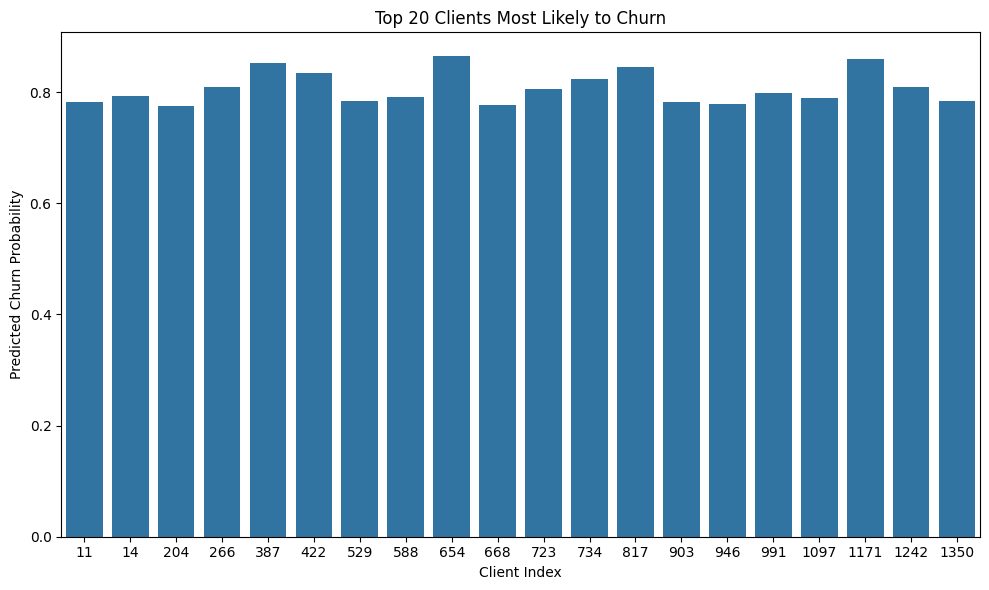

In [59]:
churn_proba = reglog.predict_proba(X_test)[:, 1]

risk_df = X_test.copy()
risk_df.reset_index(drop=True, inplace=True)
risk_df['Churn_Probability'] = churn_proba
risk_df['Actual_Churn'] = y_test.values

risk_df_sorted = risk_df.sort_values(by='Churn_Probability', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=risk_df_sorted.index[:20], y='Churn_Probability', data=risk_df_sorted[:20])
plt.title('Top 20 Clients Most Likely to Churn')
plt.ylabel('Predicted Churn Probability')
plt.xlabel('Client Index')
plt.tight_layout()
plt.show()

### Zoom on a Specific Customer (Index 654)

To better understand why the model predicts a high churn probability for a specific customer, we use SHAP to generate a local explanation.

In [60]:
shap.initjs()
shap.plots.force(shap_values[654])

#### Interpretation
For this customer, the model outputs a high churn risk (f(x) ≈ 1.83).
The main contributing factors are:

- Short tenure → new customers are more likely to churn.

- Fiber optic internet → associated with higher churn in this dataset.

- Multiple add‑on services (TV, streaming) → often linked to dissatisfaction or billing complexity.

- No long‑term contract → absence of a 2‑year agreement increases churn risk.

- Senior customer → demographic factor contributing to churn in this dataset.

- High monthly charges → may indicate perceived cost issues or service dissatisfaction.

These insights help the company understand individual churn drivers and tailor retention strategies accordingly.

## 16. Conclusion

The best-performing model for this churn prediction is **Logistic Regression** optimized with a decision threshold of **0.29**.

Model Performance:
- Recall: **0.80**
- Precision: **0.52**
- Strong interpretability
- Fast and stable

This configuration achieves a strong balance between identifying as many churners as possible (high recall) while maintaining reasonable precision. Its interpretability also makes it suitable for business decision-making and operational deployment.

### Business Takeaways
The model highlights several actionable insights:

- Prioritize new customers: Short tenure is the strongest churn driver. Early engagement and onboarding programs can significantly reduce churn.

- Monitor fiber optic users: This group shows higher churn risk, suggesting potential service quality or expectation gaps.

- Promote long-term contracts: Contract duration is one of the most protective factors against churn.

- Strengthen customer support: Features related to technical support and service usage indicate that better support could reduce churn.
